<a href="https://colab.research.google.com/github/bebyakinb/test_assignments_Analyst/blob/master/gett/matching_home_assignment_for_candidates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Тестовое задание в команду продуктовой аналитики, Gett.

В папке с заданием два датасета - data_orders - содержит выборку данных по заказам пользователей и включает такие колонки как:
* order_datetime -  время заказа
* origin_longitude - долгота
* origin_latitude - широта
* m_order_eta - время до прибытия машины
* order_gk - номер заказа
* order_status_key - статус (4 - отменен клиентом, 9 - отменен системой (reject))
* is_driver_assigned_key - был ли назначен водитель
* cancellations_time_in_seconds - сколько секунд прошло до отмены

data_offers - содержит пары номер заказа - ID оффера, который был предложен водителю по данному заказу.


В момент когда клиент нажимать на кнопку "Заказать" в приложении, система матчинга подыскивает наиболее релевантых водителей и предлагаем им заказ. В задании предлагается исследовать некоторые метрики матчинга для заказов, которые не завершились успешно (клиент в итоге не получил машину). 

**0.** Подготовка данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
! wget https://github.com/slgero/testovoe/raw/master/Gett/data/data_offers.csv

--2022-11-24 07:50:25--  https://github.com/slgero/testovoe/raw/master/Gett/data/data_offers.csv
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/slgero/testovoe/master/Gett/data/data_offers.csv [following]
--2022-11-24 07:50:25--  https://raw.githubusercontent.com/slgero/testovoe/master/Gett/data/data_offers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9027819 (8.6M) [text/plain]
Saving to: ‘data_offers.csv.1’

data_offers.csv.1   100%[===================>]   8.61M  --.-KB/s    in 0.05s   

2022-11-24 07:50:26 (168 MB/s) - ‘data_offers.csv.1’ saved [9027819/9027819]



In [ ]:
!wget https://github.com/slgero/testovoe/raw/master/Gett/data/data_orders.csv

--2022-11-24 07:50:26--  https://github.com/slgero/testovoe/raw/master/Gett/data/data_orders.csv
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/slgero/testovoe/master/Gett/data/data_orders.csv [following]
--2022-11-24 07:50:26--  https://raw.githubusercontent.com/slgero/testovoe/master/Gett/data/data_orders.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 571786 (558K) [text/plain]
Saving to: ‘data_orders.csv.1’

data_orders.csv.1   100%[===================>] 558.38K  --.-KB/s    in 0.006s  

2022-11-24 07:50:26 (96.8 MB/s) - ‘data_orders.csv.1’ saved [571786/571786]



In [ ]:
offers = pd.read_csv('data_offers.csv')
orders = pd.read_csv('data_orders.csv')

In [ ]:
offers.head()

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [ ]:
len(offers)

334363

In [ ]:
offers['order_gk'].value_counts()

3000622541299    9
3000591156831    9
3000592296546    9
3000623018231    9
3000582817158    9
                ..
3000599186936    1
3000594272454    1
3000628607809    1
3000589832090    1
3000557510943    1
Name: order_gk, Length: 97967, dtype: int64

In [ ]:
orders.head()

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   origin_longitude               10716 non-null  float64
 2   origin_latitude                10716 non-null  float64
 3   m_order_eta                    2814 non-null   float64
 4   order_gk                       10716 non-null  int64  
 5   order_status_key               10716 non-null  int64  
 6   is_driver_assigned_key         10716 non-null  int64  
 7   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(4), int64(3), object(1)
memory usage: 669.9+ KB


In [ ]:
orders['order_datetime'] = pd.to_datetime(orders['order_datetime'], format='%H:%M:%S')

**1.** Постройте распределение заказов по причинам неуспеха: отмены до и после назначения водителя, режекты

In [ ]:
orders_marked = orders.replace({'order_status_key': {4: 'отменен клиентом\n', 9: 'отменен системой (reject)\n'},
                    'is_driver_assigned_key':{0: 'водитель не был назначен', 1: 'водитель был назначен' }})

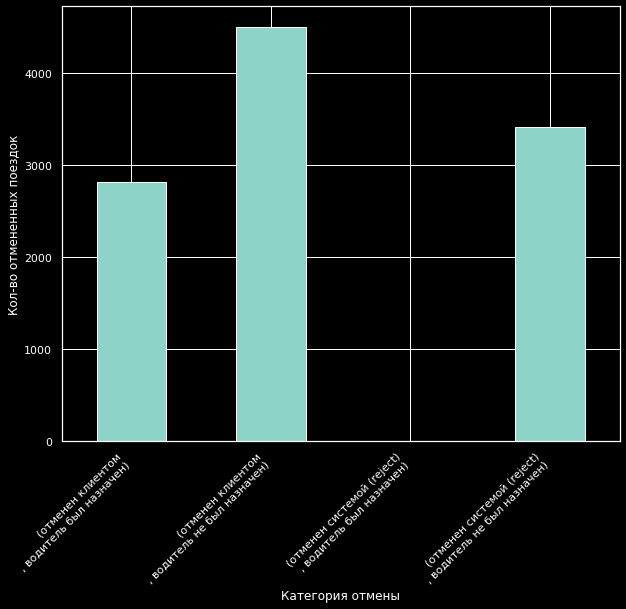

In [ ]:
pt = orders_marked.groupby(['order_status_key','is_driver_assigned_key'])['order_gk'].agg(['count'])

plt.rcParams["figure.figsize"] = (10,8)
pt.plot(kind='bar',legend=None)
plt.xticks(rotation=45,ha='right')
plt.xlabel("Категория отмены")
plt.ylabel("Кол-во отмененных поездок")

plt.show()

Проанализируйте полученный график - в какой категории наибольшое количество заказов?

Больше всего в категории отмененных клиентом, когда водитель не был назначен, в случае, если водитель был назначен, то почти в 100% отмена происходит по инициативе клиента

**2.** Постройте график распределения фейлов по часам - наблюдается ли тендеция, что в какие то часы доля той или иной категории аномально высока?

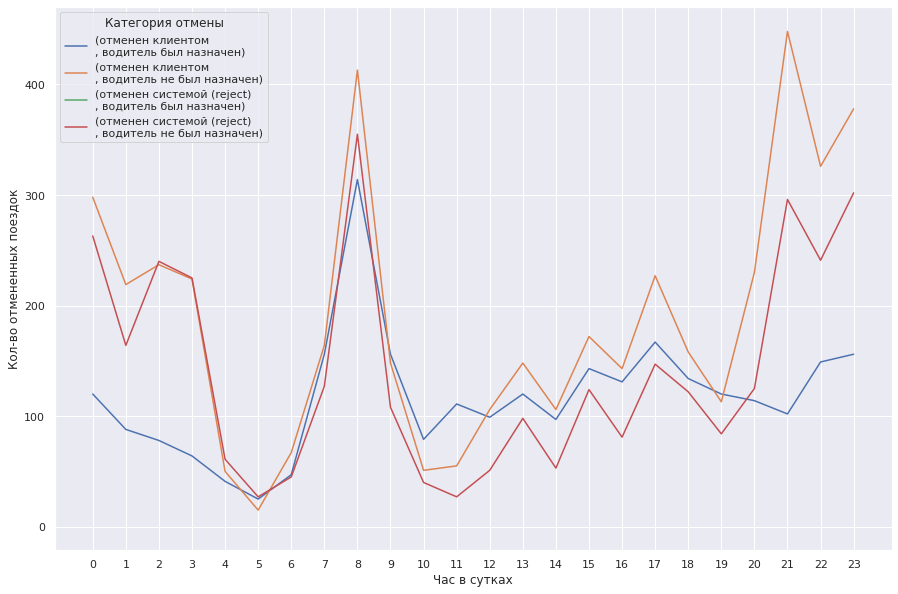

In [ ]:
orders_marked['order_hour'] = orders_marked['order_datetime'].dt.hour
pt = orders_marked.pivot_table(index='order_hour', columns=['order_status_key','is_driver_assigned_key'], values='order_gk', aggfunc='count')

sns.set()
plt.rcParams["figure.figsize"] = (15,10)
pt.plot()
plt.legend(title='Категория отмены')
plt.ylabel('Кол-во отмененных поездок')
plt.xlabel('Час в сутках')
plt.xticks(np.arange(24))
plt.show()

В какие часы фейлов больше всего? Чем это можно объяснить?


*Ответ:*Больше всего фейлов утром в 8, вероятно в это время люди заказывают такси на работу и вечерм с 21 до 00, в это время люди возвращаются домой. Примечательно, что если водиель был назначен, то отмен d ночные часы было меньше.


**3**. Постройте графики среднего времени до отмены (cancellations_time_in_seconds) с водителем и без, по часам. Если есть выбросы в данных - лучше удалить. Можно ли сделать выводы по этому графику?

In [ ]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_datetime                 10716 non-null  datetime64[ns]
 1   origin_longitude               10716 non-null  float64       
 2   origin_latitude                10716 non-null  float64       
 3   m_order_eta                    2814 non-null   float64       
 4   order_gk                       10716 non-null  int64         
 5   order_status_key               10716 non-null  int64         
 6   is_driver_assigned_key         10716 non-null  int64         
 7   cancellations_time_in_seconds  7307 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 669.9 KB


In [ ]:
orders_marked.groupby(['order_status_key','is_driver_assigned_key'])['cancellations_time_in_seconds'].agg(['mean'])

mean
order_status_key            is_driver_assigned_key              
отменен клиентом\n          водитель был назначен     233.897901
                            водитель не был назначен  110.371441
отменен системой (reject)\n водитель был назначен            NaN
                            водитель не был назначен         NaN

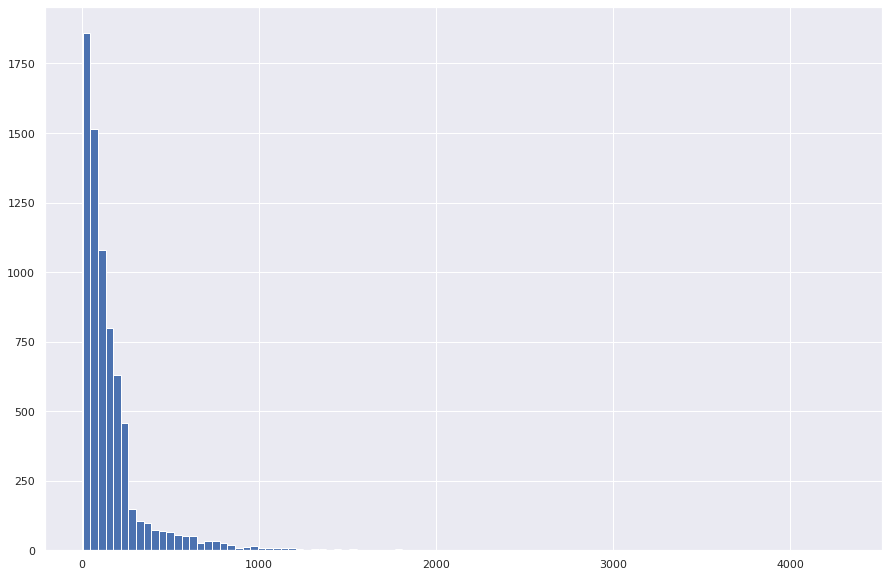

In [ ]:
orders_marked['cancellations_time_in_seconds'].hist(bins=100)

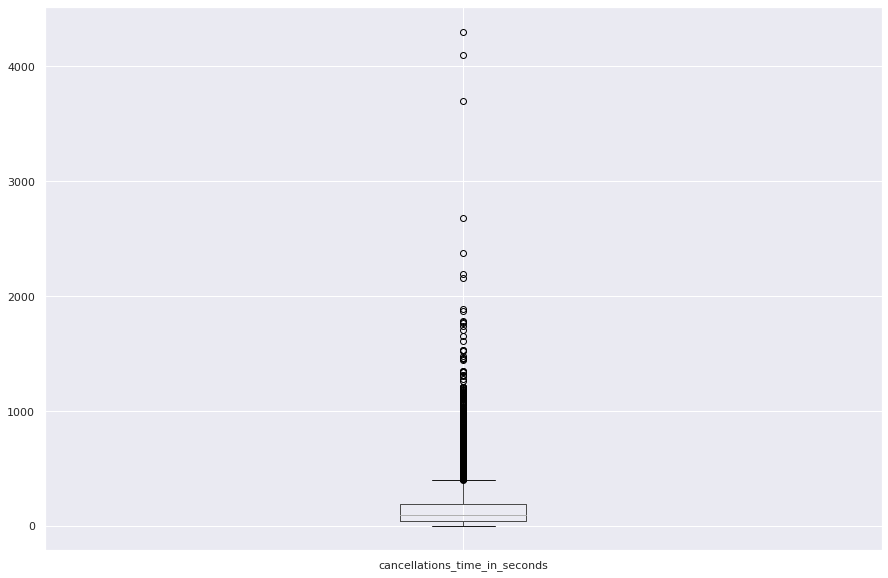

In [ ]:
orders_marked.boxplot(column=['cancellations_time_in_seconds'])

In [ ]:
orders_marked['cancellations_time_in_seconds'].describe()

count    7307.000000
mean      157.892021
std       213.366963
min         3.000000
25%        45.000000
50%        98.000000
75%       187.500000
max      4303.000000
Name: cancellations_time_in_seconds, dtype: float64

Примем правило для выбросов: Удаляем значения, которые больше или меньше на 3 межквартильных размаха от верхнего и нижнего квартилей, соотвесвенно.

In [ ]:
def remove_outlier_but_not_null(df_in, col_name):
    """
    Remove oulier from the dataframe using 3IQR rule, but safe all Null values.
    """
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-3*iqr
    fence_high = q3+3*iqr
    df_out = pd.concat([df_in[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)], df_in[(df_in[col_name].isnull())]])
    return df_out

In [ ]:
orders_cleaned = remove_outlier_but_not_null(orders_marked,'cancellations_time_in_seconds')

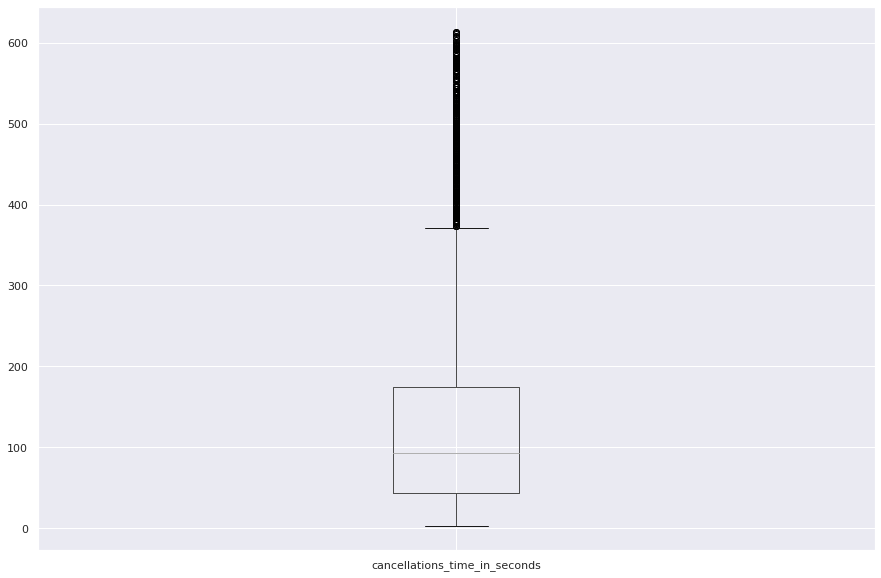

In [ ]:
orders_cleaned.boxplot(column=['cancellations_time_in_seconds'])

In [ ]:
orders_cleaned['cancellations_time_in_seconds'].describe()

count    7014.000000
mean      125.597377
std       114.778497
min         3.000000
25%        43.000000
50%        93.000000
75%       175.000000
max       614.000000
Name: cancellations_time_in_seconds, dtype: float64

In [ ]:
orders_cleaned.groupby(['order_status_key','is_driver_assigned_key'])['cancellations_time_in_seconds'].agg(['mean'])

mean
order_status_key            is_driver_assigned_key              
отменен клиентом\n          водитель был назначен     162.444880
                            водитель не был назначен  104.561702
отменен системой (reject)\n водитель был назначен            NaN
                            водитель не был назначен         NaN

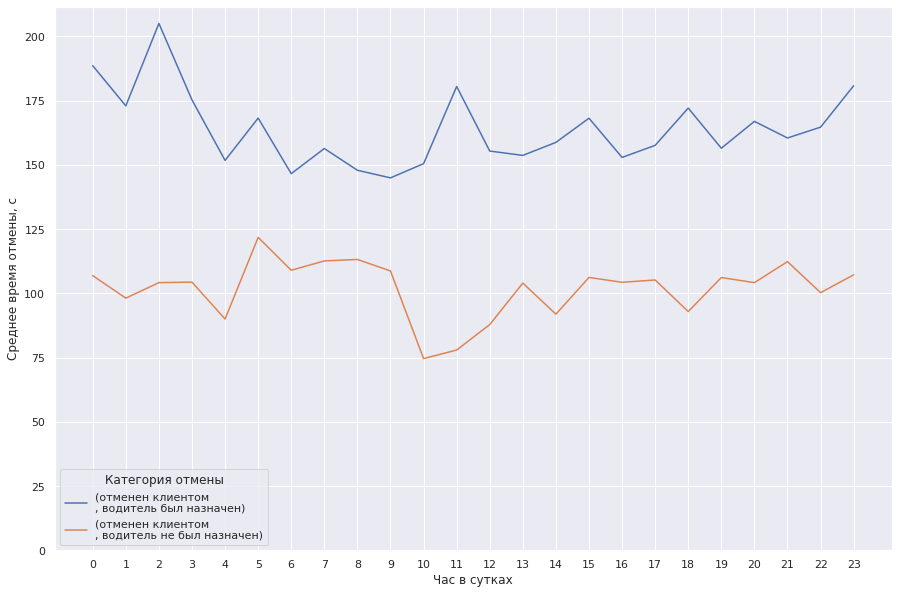

In [ ]:
orders_cleaned['order_hour'] = orders_cleaned['order_datetime'].dt.hour
pt = orders_cleaned.pivot_table(index='order_hour', columns=['order_status_key','is_driver_assigned_key'], values='cancellations_time_in_seconds', aggfunc='mean')

sns.set()
plt.rcParams["figure.figsize"] = (15,10)
pt.plot()
plt.legend(title='Категория отмены')
plt.ylabel('Среднее время отмены, с')
plt.xlabel('Час в сутках')
plt.xticks(np.arange(24))
plt.ylim(0)
plt.show()

*Ответ:* В среденем время ожидания машины примерно на 55% больше в случае, если водитель был назначен.

**4.** Постройте распределение среднего ЕТА по часам. Чем можно объяснить такой вид графика?

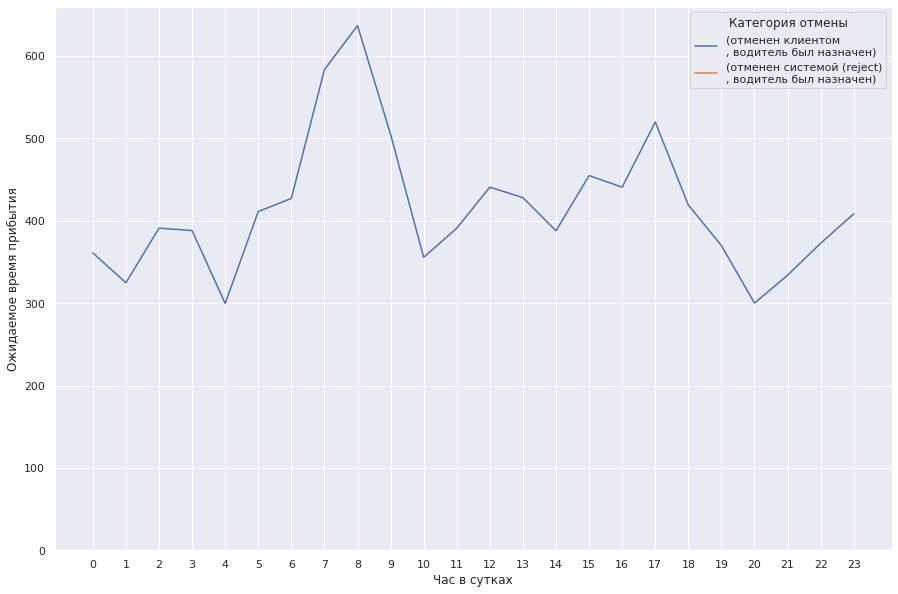

In [ ]:
pt = orders_marked.pivot_table(index='order_hour', columns=['order_status_key','is_driver_assigned_key'], values='m_order_eta', aggfunc='mean')

sns.set()
plt.rcParams["figure.figsize"] = (15,10)
pt.plot()
plt.legend(title='Категория отмены')
plt.ylabel('Ожидаемое время прибытия')
plt.xlabel('Час в сутках')
plt.ylim(0)
plt.xticks(np.arange(24))
plt.show()

*Ответ:* Наибольшое время ожидание в районе 8 утра. Можно преположить, что влияют два фактора, высокий спрос на такси перед началом рабочего дня и пробками из-за часа-пик.

5. Колонка drivers_offered - показывает сколько водителей увидели заказ и могли его принять. Постройте часовую разбивку среднего количества водителей которым был предложен заказ. Что можно сказать по ней про избыток/нехватку водителей в те или иные часы?

In [ ]:
offers.head()

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [ ]:
offers_grouped = offers.groupby(['order_gk'])['offer_id'].nunique().reset_index()
offers_grouped.rename(columns={'offer_id':'drivers_offered'}, inplace=True)
orders_with_offers = pd.merge(orders_marked, offers_grouped, on=['order_gk'], how='left')

In [ ]:
orders_with_offers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10716 entries, 0 to 10715
Data columns (total 10 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_datetime                 10716 non-null  datetime64[ns]
 1   origin_longitude               10716 non-null  float64       
 2   origin_latitude                10716 non-null  float64       
 3   m_order_eta                    2814 non-null   float64       
 4   order_gk                       10716 non-null  int64         
 5   order_status_key               10716 non-null  object        
 6   is_driver_assigned_key         10716 non-null  object        
 7   cancellations_time_in_seconds  7307 non-null   float64       
 8   order_hour                     10716 non-null  int64         
 9   drivers_offered                7610 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2), object(2)
memory usage: 920.9+ KB


In [ ]:
orders_with_offers['drivers_offered'] = orders_with_offers['drivers_offered'].fillna(0)

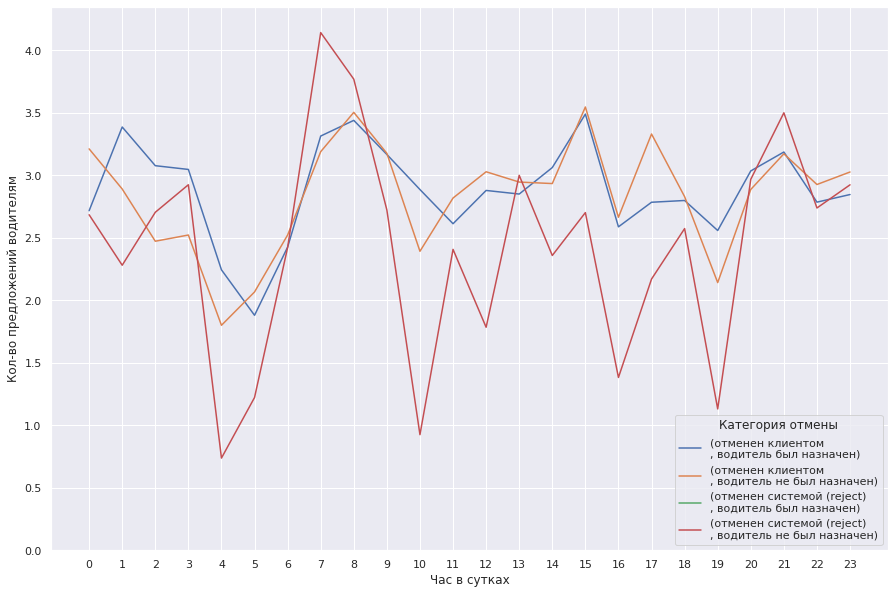

In [ ]:
pt = orders_with_offers.pivot_table(index='order_hour', columns=['order_status_key','is_driver_assigned_key'], values='drivers_offered', aggfunc='mean')

sns.set()
plt.rcParams["figure.figsize"] = (15,10)
pt.plot()
plt.legend(title='Категория отмены')
plt.ylabel('Кол-во предложений водителям')
plt.xlabel('Час в сутках')
plt.ylim(0)
plt.xticks(np.arange(24))
plt.show()

*Ответ:* Время наименьшего кол-ва предложений водителям совпадет со временем наименьшего кол-во заказов, с 4 до 6 утра, после чего кол-во предложений резко возрастает к 8 утра, особенно для заказов для которых водитель не был назначен.

**6*.** Гексаконы.
Воспользовавшись пакетами h3 и folium, посчитайте, сколько гексагонов размера 8 (https://uber.github.io/h3/#/documentation/core-library/resolution-table) содержат 80% всех заказов из исходного датасета и визуализируйте гексагон с наибольшим количеством фейлов на карте.

In [ ]:
!pip install h3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import h3

orders['hex_id'] = orders.apply(lambda row : h3.geo_to_h3(row['origin_latitude'],row['origin_longitude'],8), axis=1)

In [ ]:
hexagones = orders.groupby(['hex_id'])['order_gk'].count().sort_values(ascending=False).reset_index()

In [ ]:
hexagones.head(30)

,hex_id,order_gk
0,88195d2b1dfffff,1497
1,88195d2b1bfffff,870
2,88195d2b15fffff,774
3,88195d2b11fffff,707
4,88195d2b19fffff,667
5,88195d284dfffff,653
6,88195d2a27fffff,414
7,88195d2b0bfffff,372
8,88195d2a25fffff,362
9,88195d2b13fffff,346


In [ ]:
(hexagones['order_gk'].cumsum()/hexagones['order_gk'].sum()).head(30)

0     0.139698
1     0.220885
2     0.293113
3     0.359089
4     0.421333
5     0.482270
6     0.520903
7     0.555618
8     0.589399
9     0.621687
10    0.645670
11    0.665267
12    0.682437
13    0.699421
14    0.713979
15    0.728257
16    0.741601
17    0.753266
18    0.763998
19    0.773143
20    0.781728
21    0.790220
22    0.798152
23    0.805711
24    0.813177
25    0.820642
26    0.827548
27    0.833987
28    0.840332
29    0.846491
Name: order_gk, dtype: float64

In [ ]:
24/len(hexagones)

0.16666666666666666

*Ответ:* 24 гексагона (примерно 17% из всех гексагонов содержат 80 процентов заказов)

In [ ]:
! pip install geojson

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import folium
from geojson import Feature, Point, FeatureCollection
import json

def hexagons_dataframe_to_geojson(df_hex, file_output = None, column_name = "value"):
    """
    Produce the GeoJSON for a dataframe, constructing the geometry from the "hex_id" column
    and with a property matching the one in column_name
    """    
    list_features = []
    
    for i,row in df_hex.iterrows():
        try:
            geometry_for_row = { "type" : "Polygon", "coordinates": [h3.h3_to_geo_boundary(h=row["hex_id"],geo_json=True)]}
            feature = Feature(geometry = geometry_for_row , id=row["hex_id"], properties = {column_name : row[column_name]})
            list_features.append(feature)
        except:
            print("An exception occurred for hex " + row["hex_id"]) 

    feat_collection = FeatureCollection(list_features)
    geojson_result = json.dumps(feat_collection)
    return geojson_result

def get_color(custom_cm, val, vmin, vmax):
    return mpl.colors.to_hex(custom_cm((val-vmin)/(vmax-vmin)))

def choropleth_map(df_aggreg, column_name = "value", border_color = 'black', fill_opacity = 0.7, color_map_name = "Blues", initial_map = None):
    """
    Creates choropleth maps given the aggregated data. initial_map can be an existing map to draw on top of.
    """    
    #colormap
    min_value = df_aggreg[column_name].min()
    max_value = df_aggreg[column_name].max()

    # the name of the layer just needs to be unique, put something silly there for now:
    name_layer = "Choropleth " + str(df_aggreg)
    
    if initial_map is None:
        initial_map = folium.Map(location= [47, 4], zoom_start=5.5, tiles="cartodbpositron")

    #create geojson data from dataframe
    geojson_data = hexagons_dataframe_to_geojson(df_hex = df_aggreg, column_name = column_name)

    custom_cm = mpl.cm.get_cmap(color_map_name)

    folium.GeoJson(
        geojson_data,
        style_function=lambda feature: {
            'fillColor': get_color(custom_cm, feature['properties'][column_name], vmin=min_value, vmax=max_value),
            'color': border_color,
            'weight': 1,
            'fillOpacity': fill_opacity 
        }, 
        name = name_layer
    ).add_to(initial_map)

    return initial_map


In [ ]:
loc = orders[orders['hex_id'] == hexagones['hex_id'][0]][['origin_latitude','origin_longitude']].mean().array
loc

<PandasArray>
[51.456937507014025, -0.9706552177688712]
Length: 2, dtype: float64

In [ ]:
import folium


map = folium.Map( location=loc, zoom_start = 12)
choropleth_map(hexagones,"order_gk",initial_map=map)

map

*Ответ:* На карте отображены гексагоны всех заказов из набора данных. Чем больше заказов в гексагоне, тем выше интнесивность синего цвета.

Гексагон с наибольшим количеством фейлов находится в центре города, возле транспортного узла